# Imports and paths

In [1]:
import os
import sys

# root path
ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the project root to the Python path
if ROOT not in sys.path:
    sys.path.append(ROOT)

import polars as pl
import pandas as pd
import numpy as np

In [2]:
from config import TRAIN_PARQUET_PATH, TEST_PARQUET_PATH, PRODUCTS_PARQUET_PATH, USERS_DATA_PATH
from src.data.loaders import PolarsLoader

loader = PolarsLoader(sampling=False, file_type='parquet')

## Products

In [8]:
prods = pl.read_parquet(PRODUCTS_PARQUET_PATH, low_memory=True)
print(prods.shape)
print(prods.head())
print(prods.null_count())

(43692, 6)
shape: (5, 6)
┌──────────┬─────────────────────────────────┬────────────┬──────────┬─────────────┬────────┐
│ discount ┆ embedding                       ┆ partnumber ┆ color_id ┆ cod_section ┆ family │
│ ---      ┆ ---                             ┆ ---        ┆ ---      ┆ ---         ┆ ---    │
│ u8       ┆ list[f32]                       ┆ u16        ┆ u16      ┆ u8          ┆ u16    │
╞══════════╪═════════════════════════════════╪════════════╪══════════╪═════════════╪════════╡
│ 0        ┆ [-0.134014, -0.120043, … -0.08… ┆ 32776      ┆ 85       ┆ 4           ┆ 73     │
│ 0        ┆ [-0.094927, -0.107294, … -0.04… ┆ 41431      ┆ 135      ┆ 4           ┆ 73     │
│ 0        ┆ [-0.129044, -0.077246, … 0.002… ┆ 39419      ┆ 339      ┆ 4           ┆ 73     │
│ 1        ┆ [-0.127833, -0.133868, … -0.09… ┆ 36087      ┆ 135      ┆ 4           ┆ 73     │
│ 1        ┆ [-0.140929, -0.125828, … -0.04… ┆ 34132      ┆ 3        ┆ 4           ┆ 73     │
└──────────┴───────────────────────

In [9]:
prods['partnumber'].n_unique()

43692

### Null imputation

**Family mean (embedding)**

In [309]:
from typing import List
# # Helper function to calculate mean embedding for a group
def calc_mean_embedding(embeddings: List[np.ndarray]) -> np.ndarray:
    valid_embeddings = [e for e in embeddings if e is not None and len(e) > 0]
    return np.mean(valid_embeddings, axis=0) if valid_embeddings else np.nan

# Calculate family mean embeddings
family_means = (
    prods
    .group_by('family')
    .agg(pl.col('embedding'))
    .with_columns(
        mean_embedding=pl.col('embedding').map_elements(calc_mean_embedding, return_dtype=pl.List(pl.Float32))
    )
)

In [310]:
prods = prods.join(family_means.select(['family', 'mean_embedding']), on='family', how='left')
prods = prods.with_columns([
    pl.when(pl.col('embedding').is_null())
        .then(pl.col('mean_embedding'))
        .otherwise(pl.col('embedding'))
        .alias('embedding')
])
prods.null_count()

discount,embedding,partnumber,color_id,cod_section,family,mean_embedding
u32,u32,u32,u32,u32,u32,u32
0,8,0,0,90,0,8


**Overall mean (embedding)**

In [311]:
# Calculate family mean embeddings
overall_mean = calc_mean_embedding(prods['embedding'])
overall_mean

array([-0.0838317 ,  0.16371717, -0.10474381, ...,  0.15199807,
        0.00643364,  0.04516459], shape=(1280,), dtype=float32)

In [312]:
prods = prods.with_columns([
    pl.when(pl.col("embedding").is_null())
        .then(pl.lit(pl.Series([overall_mean])))  # Convert numpy array to Polars Series
        .otherwise(pl.col('embedding'))
        .alias('embedding')
]).drop('mean_embedding')
prods.null_count()

discount,embedding,partnumber,color_id,cod_section,family
u32,u32,u32,u32,u32,u32
0,0,0,0,90,0


In [313]:
# # Inspect lengths of embeddings
# prods_imputed = prods.to_pandas()
# embedding_lengths = prods_imputed['embedding'].apply(lambda x: len(x) if x is not None else None)

# # Check for unique lengths
# print(embedding_lengths.unique())  # Should ideally show one value, e.g., [1280]

# # Find problematic rows (if any)
# problematic_rows = prods_imputed[embedding_lengths != 1280]
# print(problematic_rows)

**cod_section**

In [314]:
def fill_section_mode(products):
    # Calculate mode by family
    family_modes = (
        products.group_by('family')
        .agg(
            mode_section=pl.col('cod_section').cast(pl.String).mode().first()
        )
    )

    # Join back to fill nulls
    result = products.join(
        family_modes,
        on='family',
        how='left'
    ).with_columns(
        cod_section=pl.col('cod_section').fill_null(pl.col('mode_section').cast(pl.UInt8))
    ).drop('mode_section')

    return result

In [315]:
prods = fill_section_mode(prods)
prods.null_count()

discount,embedding,partnumber,color_id,cod_section,family
u32,u32,u32,u32,u32,u32
0,0,0,0,0,0


### PCA embeddings

In [317]:
prods_imputed = prods.clone()

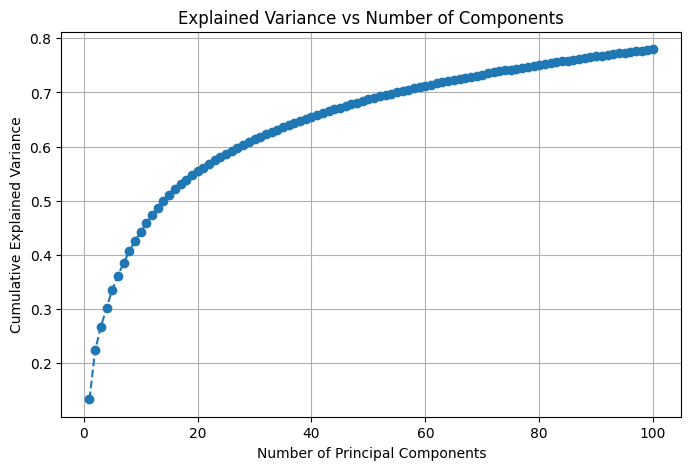

Number of components to retain 95% variance: 1


In [322]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'products['embedding']' contains the embeddings as lists of floats
embeddings = np.stack(prods_imputed['embedding'].to_numpy())

# Normalize embeddings to ensure consistency
normalized_embeddings = normalize(embeddings)

# Apply PCA
pca = PCA(n_components=100)
pca.fit(normalized_embeddings)

# Explained variance ratio
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs Number of Components')
plt.grid()
plt.show()

# Determine the number of components for 95% variance
n_components = np.argmax(explained_variance >= 0.95) + 1
print(f"Number of components to retain 95% variance: {n_components}")

## Train and test processing

In [3]:
train = loader.load_data(path=TRAIN_PARQUET_PATH)
test = loader.load_data(path=TEST_PARQUET_PATH)
train.head()

session_id,date,timestamp_local,add_to_cart,user_id,country,partnumber,device_type,pagetype
u32,date,datetime[μs],u8,u32,u8,u16,u8,u8
64,2024-06-06,2024-06-06 16:43:17.389,0,null,29,14327,1,24
117,2024-06-08,2024-06-08 15:11:02.782,0,null,57,38422,1,24
117,2024-06-08,2024-06-08 15:11:44.797,0,null,57,19763,1,24
579,2024-06-05,2024-06-05 19:24:48.397,0,null,29,30253,1,24
1220,2024-06-04,2024-06-04 08:21:13.476,0,480729,25,1592,1,24


In [22]:
print("Unique session IDs")
print(train['session_id'].n_unique())

Unique session IDs
4573756


In [6]:
test.null_count()

session_id,date,timestamp_local,user_id,country,partnumber,device_type,pagetype
u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,23509,0,0,0,0


In [7]:
print(train.shape, test.shape)

(46551445, 9) (29275, 8)


In [16]:
train.null_count()

session_id,date,timestamp_local,add_to_cart,user_id,country,partnumber,device_type,pagetype
u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,39694715,0,0,0,1197


In [23]:
df = train.filter(pl.col('session_id') == 2076921).sort('timestamp_local')
df

session_id,date,timestamp_local,add_to_cart,user_id,country,partnumber,device_type,pagetype
u32,date,datetime[μs],u8,u32,u8,u16,u8,u8
2076921,2024-06-11,2024-06-11 23:47:51.411,0,null,29,37857,3,24
2076921,2024-06-11,2024-06-11 23:48:18.931,0,null,29,34242,3,24
2076921,2024-06-11,2024-06-11 23:48:21.063,0,null,29,5785,3,24
2076921,2024-06-11,2024-06-11 23:48:24.248,0,null,29,34242,3,24
2076921,2024-06-11,2024-06-11 23:48:25.571,0,null,29,29424,3,24
…,…,…,…,…,…,…,…,…
2076921,2024-06-11,2024-06-11 23:50:52.886,0,null,29,3076,3,24
2076921,2024-06-11,2024-06-11 23:51:04.643,0,null,29,12641,3,24
2076921,2024-06-11,2024-06-11 23:51:10.625,1,null,29,3076,3,24


In [24]:
df['partnumber'].value_counts()

partnumber,count
u16,u32
5667,1
29424,3
5785,1
12641,1
37857,1
3076,3
28617,1
4774,1
34242,5


In [31]:
df.group_by('session_id').agg(pl.col('partnumber').count())

session_id,partnumber
u32,u32
2076921,17


## Users data

In [33]:
users = pl.read_parquet(USERS_DATA_PATH, low_memory=True).rename({'country': 'user_country'})
print(users.head())
print(users.null_count())

shape: (5, 5)
┌──────────────┬─────┬─────┬───────────┬─────────┐
│ user_country ┆ R   ┆ F   ┆ M         ┆ user_id │
│ ---          ┆ --- ┆ --- ┆ ---       ┆ ---     │
│ u8           ┆ u16 ┆ u16 ┆ f32       ┆ u32     │
╞══════════════╪═════╪═════╪═══════════╪═════════╡
│ 25           ┆ 30  ┆ 0   ┆ 0.0       ┆ 430102  │
│ 25           ┆ 177 ┆ 1   ┆ 75.900002 ┆ 134198  │
│ 25           ┆ 32  ┆ 61  ┆ 37.694057 ┆ 134207  │
│ 25           ┆ 74  ┆ 86  ┆ 11.64094  ┆ 180365  │
│ 25           ┆ 79  ┆ 5   ┆ 30.283333 ┆ 430101  │
└──────────────┴─────┴─────┴───────────┴─────────┘
shape: (1, 5)
┌──────────────┬─────┬─────┬─────┬─────────┐
│ user_country ┆ R   ┆ F   ┆ M   ┆ user_id │
│ ---          ┆ --- ┆ --- ┆ --- ┆ ---     │
│ u32          ┆ u32 ┆ u32 ┆ u32 ┆ u32     │
╞══════════════╪═════╪═════╪═════╪═════════╡
│ 0            ┆ 0   ┆ 0   ┆ 0   ┆ 0       │
└──────────────┴─────┴─────┴─────┴─────────┘
